# Path and shape regimes of rising bubbles

## Starting point

Our goal is to predict the path and shape regime of rising bubbles depending on the Eötvös and Galilei number defined as

$$
  Ga = \frac{\sqrt{gR}R}{\nu},\quad \text{and}\quad Eo = \frac{\rho gR^2}{\sigma},
$$

with the variables being $g$ - gravitational constant, $\nu$ - kinematic liquid viscosity, $\rho$ - liquid density, and $R$ - equivalent sphere radius. The Galilei number relates interia, buoyancy, and viscous forces. The Eötvös number relates buoyancy and surface tension forces. The path and shape regimes encountered in the range $Ga\in \left[0, 800\right]$ and $Eo\in \left[0,500\right]$ are:

1. axis-symmetric shape, straight rise
2. asymmetric shape, non-oscillatory rise
3. asymmetric shape, oscillatory rise
4. peripheral breakup
5. central breakup

**Why would we want such a classifier?**

Consider the follwoing scenarios:

* The goal is to design a multiphase reactor. The reactor ought to operate in a homgeneous regime. For a given liquid, you want know how large the bubbles sparged into the reactor can be to rise on a non-oscillatory path. Of course, the size could be determined graphically from a plot, but if the process is to be automated (e.g., in a software), a functional relationship between size and regime is required.
* In a real bubble column reactor, bubbles in all kinds of regimes will occur. In a scale reduced simulation of such a reactor, closure models have to be defined, e.g. the drag coefficient in an Euler-Lagrange solver. The standard approach would be to use simple correlations by *Schiller and Naumann* (particles) or by *Tomiyama* (bubbles). Presumably the correlations will be used far outside their actual range of validity, but actual there many more correlations available for smaller sub-regimes. The classifier can be used to build a unified correlation covering a much wider parameter range with higher accuracy by automatically switching between different suitable correlations.

The following data was extracted from figure 1 in [Tripathi et al.](https://www.nature.com/articles/ncomms7268)
> Tripathi, M. K. et al. Dynamics of an initially spherical bubble rising in quiescent liquid. Nat. Commun. 6:6268 doi: 10.1038/ncomms7268 (2015)

In general, it would be sensible to gather data form as many sources as possible. The data could also be contradictory, e.g., close to decision boundaries. Most classification algorithms are robust enough to handle such data by drawing decision boundaries accroding to the *majority*.

In [36]:
import pandas as pd

data_path = "../data/path_shape_regimes/"
regimes = ["I", "II", "III", "IV", "V"]
raw_data_files = ["regime_{}.csv".format(regime) for regime in regimes]
files = [pd.read_csv(data_path + file, header=0, names=["Ga", "Eo"]) for file in raw_data_files]
for file, regime in zip(files, regimes):
    file["regime"] = regime
data = pd.concat(files, ignore_index=True)
print("Read {} data points".format(data.shape[0]))
data.sample(5)

Read 103 data points


,Ga,Eo,regime
70,305.350,6.66400,IV
11,22.375,0.10129,I
78,70.955,47.79300,V
83,101.128,50.20600,V
99,508.960,39.89600,V


 ## Data visualization
 
 To obtain clear stability regions as in figure 1 of the article referenced above, it is advantageous to use the **logarithm** of the features $Ga$ and $Eo$.

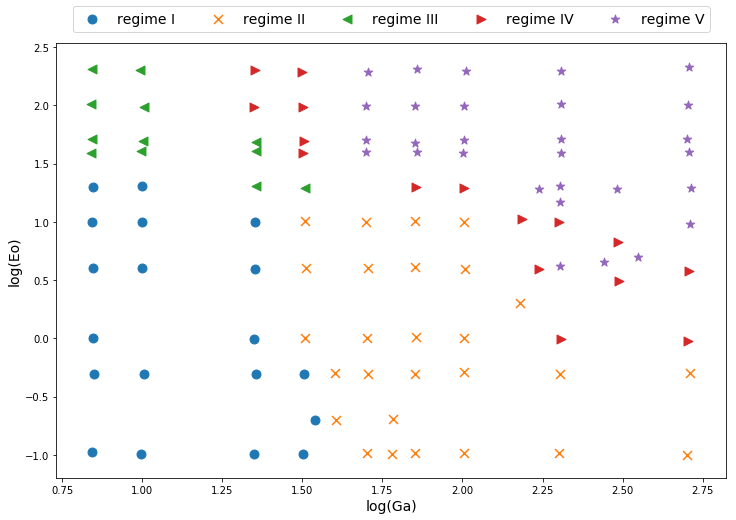

In [64]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
fontsize = 14

logData = data[["Ga", "Eo"]].apply(np.log10)
logData["regime"] = data["regime"].copy()

markers = ["o", "x", "<", ">", "*"]
plt.figure(figsize=(12, 8))
for regime, marker in zip(regimes, markers):
    plt.scatter(logData[logData["regime"] == regime].Ga, logData[logData["regime"] == regime].Eo,
                marker=marker, s=80, label="regime {}".format(regime))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5, fontsize=fontsize)
plt.xlabel(r"log(Ga)", fontsize=fontsize)
plt.ylabel(r"log(Eo)", fontsize=fontsize)
plt.show()

## Manuel binary classification - creating a functional relationship

First, we try to write a classifier by hand. To simplify things, we focus only on regime I and II. From the plot above, the data points of region I and II look almost linearly separable. Therefore, we will define a linear function $\varphi(Ga^\prime, Eo^\prime) = w_1Ga^\prime + w_2Eo^\prime + b$ with the transformed features $Ga^\prime = log(Ga)$ and $Eo^\prime = log(Eo)$ and build a classifier that distingishes the cases

$$
C(\varphi (Ga^\prime, Eo^\prime)) = \left\{\begin{array}{lr}
    0, & \text{if } \varphi \leq 0\\
    1, & \text{if } \varphi \gt 0
    \end{array}\right\}
$$

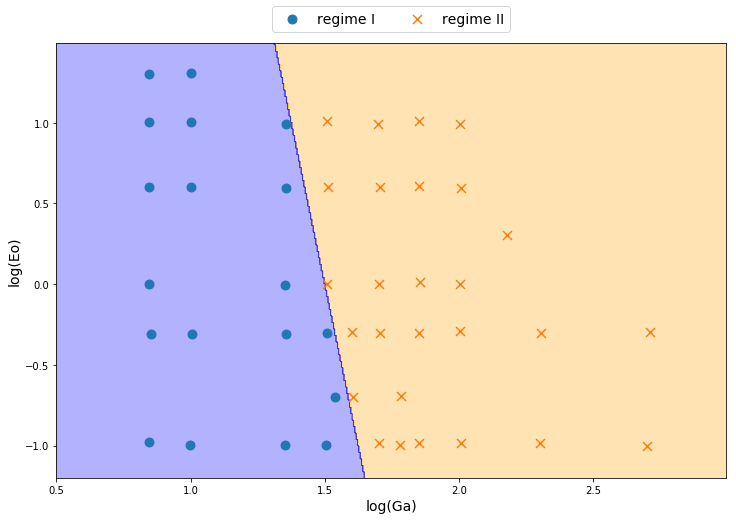

In [84]:
from matplotlib.colors import ListedColormap

resolution = 0.005

def phi(logGa, logEo):
    w1 = -8.0
    w2 = -1
    b = 12.0
    return w1 * logGa + w2 * logEo + b


def classifier(logGa, logEo):
    return np.heaviside(phi(logGa, logEo), 0.0)
    
    
plt.figure(figsize=(12, 8))

# color predicted region I and II
xx, yy = np.meshgrid(np.arange(0.5, 3.0, resolution), np.arange(-1.2, 1.5, resolution))
prediction = classifier(xx.ravel(), yy.ravel())
plt.contourf(xx, yy, prediction.reshape(xx.shape), cmap=ListedColormap(['orange', 'blue']), alpha=0.3)

# plot data point for region I and II
for regime, marker in zip(regimes[:2], markers[:2]):
    plt.scatter(logData[logData["regime"] == regime].Ga, logData[logData["regime"] == regime].Eo,
                marker=marker, s=80, label="regime {}".format(regime))


plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5, fontsize=fontsize)
plt.xlabel(r"log(Ga)", fontsize=fontsize)
plt.ylabel(r"log(Eo)", fontsize=fontsize)
plt.show()

The classifier predicts points of region I and II in the data set correctly. But there is some space for improvement:
* we had to figure out the functional relationship for $\varphi$ manually
* the decision boundary does not look always ideal; since we have no knowledge of the true decision boundary but some data points, it would be resonable to search for a boundary which maximizes the distance to the points closest to the boundary
* if we include more regimes, it will become more and more challanging if not impossible to separate the different regions
* the approach only works for linearly separable data

## Using gradient descent to find the parameters/weights

In the previous section, we manually search for the slope and offset of a linear function to separate the two classes. This process can be automated by defining and solving an optimization problem. One option would be to define a loss function which expresses the prediction quality. The true label $C$ is known for all points $i$ in the data set. The value of $C$ is $0$ for region I and $1$ for region II. The predicted label $\hat{C}$ depends on $\phi$ and therefore on the weights $p = \left[w_1, w_2, b\right]$. A common loss is the squared difference of true and predicted label $(C-\hat{C})^2$ for all $N$ data points:

$$
  L(p) = \frac{1}{2}\sum\limits_{i=1}^N \left(C_i - \hat{C}_i \right)^2
$$

The prefactor $1/2$ is only for convenience, as will become clear later on. The knobs we can turn to minimize the loss are the weights $p$. The most common algorithm to find suitable weights in machine learning is gradient descent. The idea is to compute the gradient of the loss function w.r.t. the weights and then to change  the weights in small steps in negative gradient direction. The gradient of $L$ is

$$
  \nabla L =
  \begin{pmatrix}\frac{\partial L}{\partial w_1}\\
                 \frac{\partial L}{\partial w_2}\\
                 \frac{\partial L}{\partial b}
  \end{pmatrix}= 
$$

In [ ]:
# next:
# - probailities
# - non-linear transformation
# - MLP
# - multi-class classification